In [1]:
import json
import pystac
import stackstac
import os
import xarray as xr
import geopandas as gpd
from shapely import Polygon
import matplotlib.pyplot as plt
import pandas as pd
import rioxarray as rio
from rasterio.crs import CRS
import rasterio 
import matplotlib.patches as mpatches
import numpy as np
import scipy
from scipy.stats import sem

from geocube.api.core import make_geocube
from geocube.rasterize import rasterize_image

In [2]:
import sys
sys.path.insert(0, '/uufs/chpc.utah.edu/common/home/u1269862/2023/expanding_retreat/expanding_retreat/')

import retreat_setup_tools
import retreat_processing_tools

## Read in data

In [3]:
rgi_path = '/uufs/chpc.utah.edu/common/home/u1269862/2023/new_retreat/data/rgi/rgi15/'
rgi15 = gpd.read_file(os.path.join(rgi_path, '15_rgi60_SouthAsiaEast.shp'))
rgi15_prj = rgi15.to_crs('EPSG:32645')

### UTM + country borders

In [4]:
utm = gpd.read_file('/uufs/chpc.utah.edu/common/home/u1269862/2023/new_retreat/data/utm/World_UTM_Grid(1).geojson')


In [5]:
utm45 = utm.loc[utm['ZONE'] == 45]
utm45 = gpd.sjoin(utm45, rgi15, how='inner')

In [6]:
utm45_prj = utm45.to_crs('EPSG:32645')
utm45_prj = utm45_prj.drop('index_right', axis=1)

In [7]:
borders = gpd.read_file('/uufs/chpc.utah.edu/common/home/u1269862/2022/border_data/Asia_Russia.shp')
countries = ['NEPAL','BHUTAN']
asia = borders.loc[(borders['REGION'] == 'ASIA') & (borders['NAME'].isin(countries))]

### NASADEM

In [8]:
nasadem_dir = '/uufs/chpc.utah.edu/common/home/cryosphere/emarshall/nasadem/'
downsamp_fname = '414_downsamp_prj_dem.nc'

In [9]:
dem = xr.open_dataset(os.path.join(nasadem_dir, downsamp_fname)).squeeze().rio.write_crs('EPSG:32645')


In [10]:
dem = dem.rename({'lon':'x','lat':'y'})

In [11]:
dem_fp = retreat_processing_tools.get_footprint(dem, 'xy').set_crs('EPSG:32645')
        

In [12]:
dem_bbox = [dem_fp.bounds['minx'].values[0], dem_fp.bounds['miny'].values[0], 
            dem_fp.bounds['maxx'].values[0], dem_fp.bounds['maxy'].values[0]]

### Subset RGI by nasadem

In [13]:
rgi_subset = gpd.sjoin(rgi15_prj, dem_fp, how='inner').drop('index_right',axis=1)

In [14]:
rgi_ids = rgi_subset['RGIId'].to_list()

### RETREAT

In [15]:
catalog = pystac.Catalog.from_file('/uufs/chpc.utah.edu/common/home/u1269862/2023/expanding_retreat/retreat_stac_catalog/catalog.json')


In [16]:
items = list(catalog.get_all_items())


In [17]:
cube = stackstac.stack(
    items = [item.to_dict() for item in items],
    bounds=dem_bbox, snap_bounds=False)

In [18]:
cube = retreat_processing_tools.cube_process(cube)

In [24]:
def compare_raster_extents(dem_raster, retreat_raster):
    '''this is to check the extents of the nasadem and retreat object read in w/stackstac. 
    they should be the same bc the dem bounds are given as an arg to stackstac.stack() but 
    sometimes there is a discrepancy
    '''
    
    
    dem_fp = retreat_processing_tools.get_footprint(dem_raster,'xy')
    retreat_fp = retreat_processing_tools.get_footprint(retreat_raster,'xy')
    
    compare_df = dem_fp.bounds == retreat_fp.bounds
    
    if compare_df['minx'][0] == True and compare_df['maxx'][0] == True and compare_df['miny'][0] == True and compare_df['maxy'][0] == True:
        print('bounds are a match')
        return dem_raster
    else:
        print('bounds are not a match, slicing dem by retreat')
        dem_raster = dem_raster.sel(x=slice(retreat_raster.x.min().data, retreat_raster.x.max().data))
        dem_raster = dem_raster.sel(y=slice(retreat_raster.y.min().data, retreat_raster.y.max().data))
        
        return dem_raster
    

In [25]:
dem = compare_raster_extents(dem, cube)


bounds are a match


In [26]:
cube_footprint = retreat_processing_tools.get_footprint(cube, 'xy')

In [27]:
dem_footprint= retreat_processing_tools.get_footprint(dem,'xy')

In [28]:
dem_footprint.bounds == cube_footprint.bounds

,minx,miny,maxx,maxy
0,True,True,True,True


## 4/26 Dry run reprocessing RETREAT subsetting by z-quintiles

In [30]:
rgi_02235  = rgi_subset.loc[rgi_subset['RGIId'] == 'RGI60-15.02235']

In [34]:
cube_02235 = cube.rio.clip(rgi_02235.geometry, rgi_02235.crs)

In [31]:
dem_02235 = dem.rio.clip(rgi_02235.geometry, rgi_02235.crs)

In [98]:
dem_02235 = dem_02235.expand_dims('z')

In [99]:
dem_02235

<xarray.Dataset>
Dimensions:  (y: 26, x: 28, z: 1)
Coordinates:
  * y        (y) float64 3.078e+06 3.078e+06 3.078e+06 ... 3.083e+06 3.083e+06
  * x        (x) float64 7.262e+05 7.264e+05 7.266e+05 ... 7.314e+05 7.316e+05
    crs      int64 0
Dimensions without coordinates: z
Data variables:
    Band1    (z, y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    Conventions:  CF-1.5
    GDAL:         GDAL 3.5.2, released 2022/09/02
    history:      Thu Apr 13 14:51:17 2023: GDAL Create( /home/emmamarshall/D...

In [104]:
p1 = np.nanpercentile(dem_02235.Band1.data, 20)
p1

4553.73388671875

In [105]:
q1 = np.nanquantile(dem_02235.Band1.data, 0.2)
q1

4553.73388671875

In [106]:
np.count_nonzero(dem_02235.Band1.data <= np.nanquantile(dem_02235.Band1.data, 0.2))

26

In [115]:
np.count_nonzero((dem_02235.Band1.data > np.nanquantile(dem_02235.Band1.data, 0.2)) & (dem_02235.Band1.data <= np.nanquantile(dem_02235.Band1.data, 0.4)))

25

In [116]:
np.count_nonzero((dem_02235.Band1.data > np.nanquantile(dem_02235.Band1.data, 0.4)) & (dem_02235.Band1.data <= np.nanquantile(dem_02235.Band1.data, 0.6)))

25

In [117]:
np.count_nonzero((dem_02235.Band1.data > np.nanquantile(dem_02235.Band1.data, 0.6)) & (dem_02235.Band1.data <= np.nanquantile(dem_02235.Band1.data, 0.8)))

25

In [118]:
np.count_nonzero((dem_02235.Band1.data > np.nanquantile(dem_02235.Band1.data, 0.8)) & (dem_02235.Band1.data <= np.nanquantile(dem_02235.Band1.data, 1)))

25

In [121]:
dem_02235_z0 = dem_02235.where(dem_02235.Band1 <= np.nanquantile(dem_02235.Band1, 0.2), drop=True)
#dem_02235_z1 = dem_02235.where((dem_02235.Band1.data > np.nanquantile(dem_02235.Band1.data, 0.2)) & (dem_02235.Band1.data <= np.nanquantile(dem_02235.Band1.data, 0.4)), drop=True)
#dem_02235_z2 = dem_02235.where((dem_02235.Band1.data > np.nanquantile(dem_02235.Band1.data, 0.4)) & (dem_02235.Band1.data <= np.nanquantile(dem_02235.Band1.data, 0.6)), drop=True)
#dem_02235_z3 = dem_02235.where((dem_02235.Band1.data > np.nanquantile(dem_02235.Band1.data, 0.6)) & (dem_02235.Band1.data <= np.nanquantile(dem_02235.Band1.data, 0.8)), drop=True)
#dem_02235_z4 = dem_02235.where((dem_02235.Band1.data > np.nanquantile(dem_02235.Band1.data, 0.8)) & (dem_02235.Band1.data <= np.nanquantile(dem_02235.Band1.data, 1)), drop=True)

In [145]:
np.count_nonzero(~np.isnan(dem_02235.Band1.data))

126

In [124]:
np.count_nonzero(~np.isnan(dem_02235_z0.Band1.data))

26

In [125]:
np.count_nonzero(~np.isnan(dem_02235_z1.Band1.data))

25

In [126]:
np.count_nonzero(~np.isnan(dem_02235_z2.Band1.data))

25

In [127]:
np.count_nonzero(~np.isnan(dem_02235_z3.Band1.data))

25

In [128]:
np.count_nonzero(~np.isnan(dem_02235_z4.Band1.data))

25

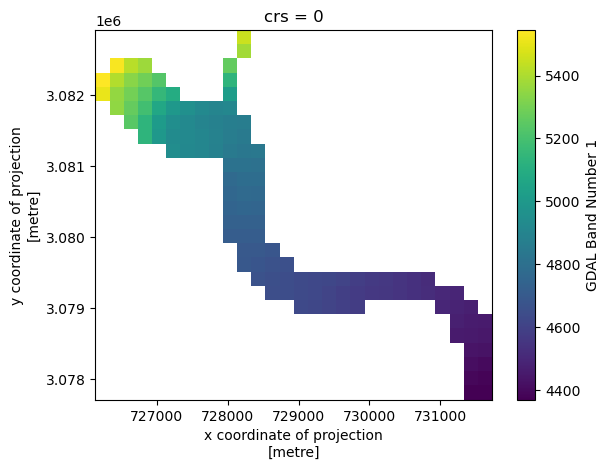

In [88]:
dem_02235.Band1.plot()

In [133]:
dem_02235_z0.Band1.shape[1]*dem_02235_z0.Band1.shape[2]

72

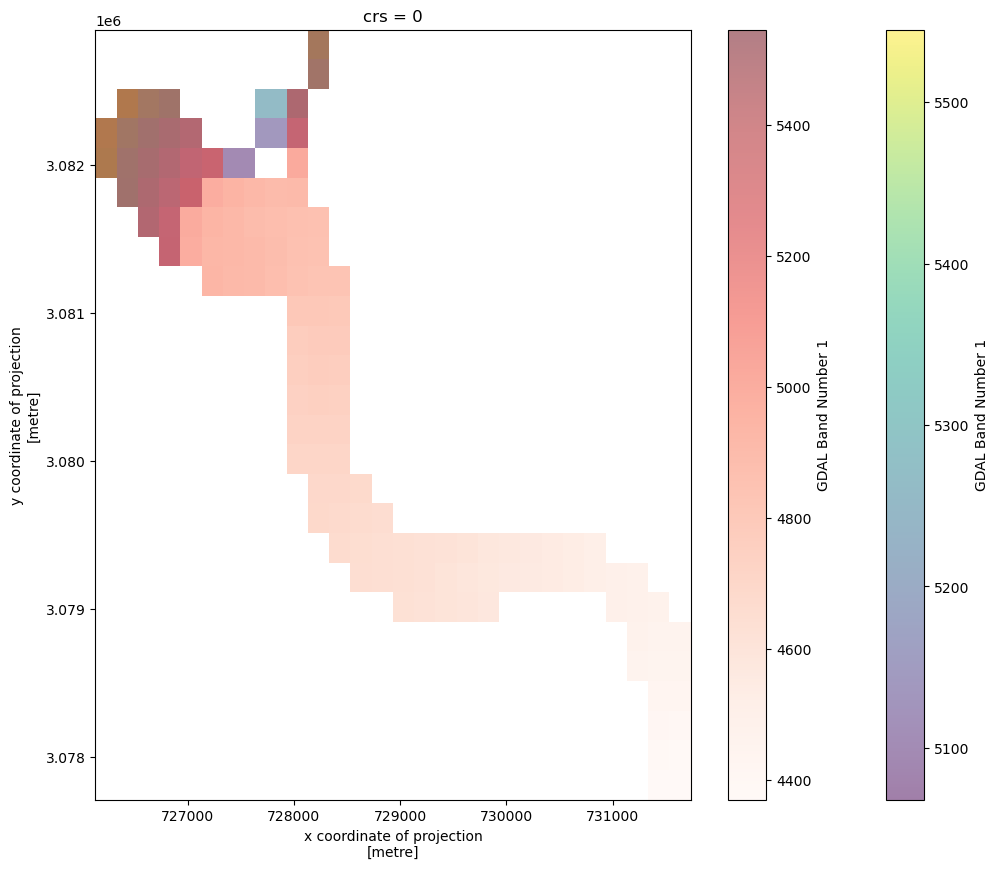

In [143]:
fig,ax = plt.subplots(figsize=(12,10))
#dem_02235_z0.Band1.plot(ax=ax)
#dem_02235_z1.Band1.plot(ax=ax)
#dem_02235_z2.Band1.plot(ax=ax)
#dem_02235_z3.Band1.plot(ax=ax)
dem_02235_z4.Band1.plot(ax=ax, alpha = 0.5)

dem_02235.Band1.plot(ax=ax, alpha=  0.5, cmap=plt.cm.Reds)


In [46]:
np.nanquantile(dem_02235.Band1, 0)

4369.8345

In [43]:
np.nanmin(dem_02235.Band1)

4369.8345

In [39]:
np.nanquantile(dem_02235.Band1, 0.2)

4553.73388671875

In [40]:
np.nanquantile(dem_02235.Band1, 0.4)

4665.12939453125

In [41]:
np.nanquantile(dem_02235.Band1, 0.6)

4839.71630859375

In [42]:
np.nanquantile(dem_02235.Band1, 0.8)

5017.60107421875

In [44]:
np.nanmax(dem_02235.Band1)

5544.9897

In [45]:
np.nanquantile(dem_02235.Band1, 1)

5544.9897

In [165]:
ds_02235 = velocity_clip(cube, rgi_02235)

In [166]:
ds_02235 = dem_clip(ds_02235, dem, rgi_02235)

In [167]:
ds_02235 = elevation_format(ds_02235)

In [161]:
print(np.count_nonzero(~np.isnan(ds_02235.z_q1)))
print(np.count_nonzero(~np.isnan(ds_02235.z_q2)))
print(np.count_nonzero(~np.isnan(ds_02235.z_q3)))
print(np.count_nonzero(~np.isnan(ds_02235.z_q4)))
print(np.count_nonzero(~np.isnan(ds_02235.z_q5)))


26
25
25
25
25


In [171]:
ds_02235 = add_mask_var(ds_02235, rgi_02235)

In [195]:
ds_02235.where(ds_02235.z_lower.notnull(),drop=True).mask

<xarray.DataArray 'mask' (y: 14, x: 19)>
array([[5.01,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan],
       [5.01, 5.01, 5.01,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan],
       [5.01, 5.01, 5.01,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan],
       [ nan, 5.01, 5.01, 5.01,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan],
       [ nan, 5.01, 5.01, 5.01, 5.01,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan],
       [ nan,  nan, 5.01, 5.01, 5.01, 5.01, 5.01, 5.01, 5.01, 5.01, 5.01,
        5.01, 5.01, 5.01, 5.01,  nan,  nan,  nan,  nan],
       [ nan,  nan,  nan, 5.01, 5.01, 5.01, 5.01, 5.01, 5.01, 5.01, 5.01,
        5.01, 5.01, 5.01, 5.01, 5.01, 5.01,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan, 5.01, 5.01, 5.01, 5.01, 5.01,  nan,
         nan,  nan,  nan,  nan, 5.01, 5.01, 5.01,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan, 5.01, 5.01, 5.01],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan, 5.01, 5.01, 5.01],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan, 5.01, 5.01],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan, 5.01, 5.01],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan, 5.01, 5.01],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan, 5.01, 5.01]])
Coordinates:
  * x            (x) float64 7.28e+05 7.282e+05 ... 7.314e+05 7.316e+05
  * y            (y) float64 3.08e+06 3.08e+06 3.08e+06 ... 3.078e+06 3.078e+06
    site         <U2 '10'
    sensor       <U2 'S1'
    title        <U7 'dis_mag'
    proj:epsg    int64 32645
    epsg         int64 32645
    spatial_ref  int64 0
    crs          int64 0
Attributes:
    name:        Area
    long_name:   Area
    _FillValue:  -999.0

In [190]:
np.count_nonzero(~np.isnan(ds_02235.where(ds_02235.z_upper.notnull(),drop=True).mask))

63

In [191]:
np.count_nonzero(~np.isnan(ds_02235.where(ds_02235.z_lower.notnull(),drop=True).mask))

63

In [174]:
np.count_nonzero(ds_02235.mask > 0)

126

## Okay, now trying to do processing by segments....

In [196]:
def velocity_clip(ds, rgi):
    
    ds_clip = ds.rio.clip(rgi.geometry, rgi.crs)
    
    return ds_clip

def dem_clip(ds, dem, rgi):
    dem_clip = dem.rio.clip(rgi.geometry, rgi.crs)
    ds['z'] = dem_clip.Band1
    
    return ds

def elevation_format(ds):
    
    #zmin = np.nanmin(ds.z.data)
    #zmed = np.nanmedian(ds.z.data)
    #zmax = np.nanmedian(ds.z.data)
    
    z_lower = ds.where(ds.z <= np.nanmedian(ds.z.data), drop=True)
    z_upper = ds.where(ds.z > np.nanmedian(ds.z.data), drop=True)
    ## dem_02235.where((dem_02235.Band1.data > np.nanquantile(dem_02235.Band1.data, 0.2)) & (dem_02235.Band1.data <= np.nanquantile(dem_02235.Band1.data, 0.4)), drop=True)


    z_q1 = ds.where(ds.z <= np.nanquantile(ds.z, 0.2),drop=True)
    z_q2 = ds.where((ds.z > np.nanquantile(ds.z, 0.2)) & (ds.z <= np.nanquantile(ds.z, 0.4)), drop=True)
    z_q3 = ds.where((ds.z > np.nanquantile(ds.z, 0.4)) & (ds.z <= np.nanquantile(ds.z, 0.6)), drop=True)
    z_q4 = ds.where((ds.z > np.nanquantile(ds.z, 0.6)) & (ds.z <= np.nanquantile(ds.z, 0.8)), drop=True)
    z_q5 = ds.where((ds.z > np.nanquantile(ds.z, 0.8)) & (ds.z <= np.nanquantile(ds.z, 1.)), drop=True)

    
    ds['z_lower'] = z_lower.z
    ds['z_upper'] = z_upper.z
    
    ds['z_q1'] = z_q1.z
    ds['z_q2'] = z_q2.z
    ds['z_q3'] = z_q3.z
    ds['z_q4'] = z_q4.z
    ds['z_q5'] = z_q5.z
    
    return ds

def calc_valid(arr):
    
    i = np.count_nonzero(~np.isnan(arr))
    
    return i

def calc_full_cov(ds):
    
    #possible = np.count_nonzero(~np.isnan(ds.dis_mag.mean(dim='time')))
    possible = np.count_nonzero(ds.mask > 0)
    actual = xr.apply_ufunc(calc_valid,
                            ds.dis_mag,
                            input_core_dims=[['x','y']],
                            exclude_dims=set(('x','y')),
                            vectorize=True,
                            dask='parallelized')
    cov = actual / possible
    ds['full_actual'] = actual
    ds['full_possible'] = possible
    ds['full_cov'] = cov
    
    return ds

def calc_lower_cov(ds):
    
    #ds_sub = ds.where(ds.z <= np.nanmedian(ds.z.data),drop=True)
    ds_sub = ds.where(ds.z_lower.notnull(), drop=True)
    #possible = np.count_nonzero(~np.isnan(ds_sub.dis_mag.mean(dim='time')))
    possible = np.count_nonzero(~np.isnan(ds_sub.mask))
    actual = xr.apply_ufunc(calc_valid,
                            ds_sub.dis_mag,
                            input_core_dims=[['x','y']],
                            exclude_dims=set(('x','y')),
                            vectorize=True,
                            dask='parallelized')
    cov = actual / possible
    ds['lower_actual'] = actual
    ds['lower_possible'] = possible
    ds['lower_cov'] = cov
    return ds

def calc_upper_cov(ds):
    
    #ds_sub = ds.where(ds.z > np.nanmedian(ds.z.data),drop=True)
    ds_sub = ds.where(ds.z_upper.notnull(),drop=True)
    #possible = np.count_nonzero(~np.isnan(ds_sub.dis_mag.mean(dim='time')))
    possible = np.count_nonzero(~np.isnan(ds_sub.mask))
    actual = xr.apply_ufunc(calc_valid,
                            ds_sub.dis_mag,
                            input_core_dims=[['x','y']],
                            exclude_dims=set(('x','y')),
                            vectorize=True,
                            dask='parallelized')
    
    cov = actual / possible
    ds['upper_actual'] = actual
    ds['upper_possible'] = possible
    ds['upper_cov'] = cov
    return ds

def add_mask_var(ds, rgi):
    '''rasterize shapefile of single glacier and add it as a var to ds object
    '''
    outline_mask = make_geocube(
        vector_data = rgi,
        measurements=['Area'],
        like=ds.dis_mag,
        fill=-999.)
    ds['mask'] = outline_mask['Area']
    
    return ds

def shapefile_outline_moving_ice_comparison(ds, rgiid):
    '''function to compare the rgi outline to actual velocity data for a single glacier.
    The goal is to see if there are pixels that the RGI outline (a rasterization of it) expects
    to be ice, but are never recorded as having moving ice by the velocity dataset?
    this could indicate 2 things: the outline is outdated/incorrect, or the velocity dataset persistently
    misses glaciated pixels for the extent of the time series
    the output dataframe is labelled under the assumption that the rgi outline is accurate, 
    so 'pixels expected' is the # of pixels the rasterized outline contains, 'pixels actual' is 
    the number of pixels in teh array representing the temporal mean velocity values for the glacier
    '''
    
    num_mask = np.count_nonzero(ds.mask > 0)
    
    num_vel = np.count_nonzero(~np.isnan(ds.dis_mag.mean(dim='time')))
    
    dif = num_mask - num_vel
    
    d = {'RGIId':rgiid, 'pixels_expected':num_mask, 'pixels_actual':num_vel, 'difference': dif}
    df = pd.DataFrame(d, index=[0])
    
    return df

In [197]:
def calc_area_cov_index(ds):
    
    aci = (ds['upper_cov'] / ds['full_cov']) * (ds['upper_cov'] / (ds['upper_cov'] + ds['lower_cov']))
    
    ds['aci'] = aci
    
    return ds

In [198]:
def retreat_processing_driver(retreat_raster, dem_raster, rgi_id, rgi_gpdf):
    
    rgi_single = rgi_gpdf.loc[rgi_gpdf['RGIId'] == rgi_id]
    
    ds_clip = velocity_clip(retreat_raster, rgi_single)
    
    ds_clip = add_mask_var(ds_clip, rgi_single)
    
    ds_clip = dem_clip(ds_clip, dem_raster, rgi_single)
    
    ds_clip = elevation_format(ds_clip)
    
    ds_clip = calc_full_cov(ds_clip)
    
    ds_clip = calc_lower_cov(ds_clip)
    
    ds_clip = calc_upper_cov(ds_clip)
    
    ds_clip = calc_area_cov_index(ds_clip)
    
    return ds_clip
    
    

In [199]:
full_02235 = retreat_processing_driver(cube, dem, 'RGI60-15.02235',rgi_subset)

In [200]:
full_02235

<xarray.Dataset>
Dimensions:         (time: 1744, x: 28, y: 26)
Coordinates: (12/19)
  * time            (time) datetime64[ns] 2014-10-23 2014-10-23 ... 2022-01-15
  * x               (x) float64 7.262e+05 7.264e+05 ... 7.314e+05 7.316e+05
  * y               (y) float64 3.083e+06 3.083e+06 ... 3.078e+06 3.078e+06
    id              (time) <U19 '10_085_002_20141023' ... '10_012_087_20220115'
    img1_id         (time) <U4 '8496' '14B4' '62C5' ... 'B169' 'E490' 'EC18'
    tile            (time) <U10 '10_085_002' '10_085_001' ... '10_012_087'
    ...              ...
    epsg            int64 32645
    img1_date       (time) datetime64[ns] 2014-10-11T12:21:55 ... 2022-01-09T...
    img2_date       (time) datetime64[ns] 2014-11-04T12:21:55 ... 2022-01-21T...
    img_separation  (time) float64 24.0 24.0 24.0 24.0 ... 11.0 11.0 59.0 11.0
    spatial_ref     int64 0
    crs             int64 0
Data variables: (12/21)
    dis_mag         (time, y, x) float64 dask.array<chunksize=(1, 26, 28), meta=np.ndarray>
    dis_mag_my      (time, y, x) float64 dask.array<chunksize=(1, 26, 28), meta=np.ndarray>
    mask            (y, x) float64 -999.0 -999.0 -999.0 ... -999.0 5.01 5.01
    z               (y, x) float32 nan nan nan nan ... nan nan 4.37e+03 4.37e+03
    z_lower         (y, x) float32 nan nan nan nan ... nan nan 4.37e+03 4.37e+03
    z_upper         (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    ...              ...
    lower_possible  int64 63
    lower_cov       (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    upper_actual    (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    upper_possible  int64 63
    upper_cov       (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    aci             (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes:
    spec:           RasterSpec(epsg=32645, bounds=[301631.7369275199, 2986413...
    crs:            epsg:32645
    transform:      | 200.00, 0.00, 301631.74|\n| 0.00,-200.00, 3211613.12|\n...
    resolution_xy:  (199.99999999999997, 200.0)

In [201]:
outpath = '/uufs/chpc.utah.edu/common/home/cryosphere/emarshall/retreat_itslive_work/processed_results/retreat/426_results/'


In [202]:
already_made_ds = os.listdir(outpath)

In [203]:
already_made_ds

[]

In [204]:
def trim_cov(ds, theshold):
    
    ds = ds.where(ds['full_cov'] >= threshold, drop=True)
    ds = ds.where(ds.full_cov != 0,drop=True)
    
    return ds 

In [205]:
def process_retreat_glaciers_to_file(rgi_ids_ls, rgi_gpdf, retreat_raster, dem_raster, outpath):
    
    already_made_ds = os.listdir(outpath)
    already_made_ds = [f[3:-3] for f in already_made_ds]
    ds_ls = []
    for glacier in range(len(rgi_ids_ls)):
        
        rgi_id = rgi_ids_ls[glacier]
        print(rgi_id)
        
        if rgi_id in already_made_ds:
            
            print('already processed, written to file')
        else: 
            print('in else loop')
            try: 
                print('made it here')
                ds = retreat_processing_tools.retreat_processing_driver(retreat_raster, dem_raster, rgi_id, rgi_gpdf)
                #ds = ds.where(ds['full_cov'] >= 0.1,drop=True)
                print('cov trim done')
                ds_ls.append(ds)
                print('ds created')
                ds.to_netcdf(os.path.join(outpath, f'ds_{rgi_id}.nc'), engine='netcdf4', format='NETCDF4')
            except:
                print('some issue here, maybe an empty time step?')
                
                
    return ds_ls

In [32]:
rgi_ids_sub = rgi_ids[4:6]

In [33]:
rgi_ids_sub

['RGI60-15.02644', 'RGI60-15.02698']

In [ ]:
i = process_retreat_glaciers_to_file(rgi_ids, rgi_subset, cube, dem, outpath)


RGI60-15.02235
in else loop
made it here
velocity cilpped
dem clipped
obj loaded
cov stuff done
cov trim done
attrs reformatted
cov trim done
ds created
RGI60-15.02263
in else loop
made it here
velocity cilpped
dem clipped
obj loaded
cov stuff done
cov trim done
attrs reformatted
cov trim done
ds created
RGI60-15.02274
in else loop
made it here
velocity cilpped
dem clipped
obj loaded
cov stuff done
cov trim done
attrs reformatted
cov trim done
ds created
RGI60-15.02319
in else loop
made it here
velocity cilpped
dem clipped
obj loaded
cov stuff done
cov trim done
attrs reformatted
cov trim done
ds created
RGI60-15.02644
in else loop
made it here
velocity cilpped
dem clipped
obj loaded
cov stuff done
cov trim done
attrs reformatted
cov trim done
ds created
RGI60-15.02698
in else loop
made it here
velocity cilpped
dem clipped
obj loaded
cov stuff done
cov trim done
attrs reformatted
cov trim done
ds created
RGI60-15.02703
in else loop
made it here
velocity cilpped
dem clipped
obj loaded
c

In [35]:
i

[]

In [ ]:
i[0] = i[0].where(i[0]['full_cov'] >= 0.1,drop=True)

In [ ]:
i[0].to_netcdf(os.path.join(outpath, 'ds_RGI60-15.02235.nc'))

In [42]:
i[0]

<xarray.Dataset>
Dimensions:         (time: 1744, x: 18, y: 30)
Coordinates: (12/19)
  * time            (time) datetime64[ns] 2014-10-23 2014-10-23 ... 2022-01-15
  * x               (x) float64 7.77e+05 7.772e+05 ... 7.802e+05 7.804e+05
  * y               (y) float64 3.114e+06 3.114e+06 ... 3.108e+06 3.108e+06
    id              (time) <U19 '10_085_002_20141023' ... '10_012_087_20220115'
    img2_id         (time) <U4 'D1BD' '8C6F' '996A' ... 'AC82' 'EC18' 'A5F1'
    orbit           (time) <U3 '002' '001' '001' '001' ... '068' '087' '087'
    ...              ...
    epsg            int64 32645
    img1_date       (time) datetime64[ns] 2014-10-11T12:21:55 ... 2022-01-09T...
    img2_date       (time) datetime64[ns] 2014-11-04T12:21:55 ... 2022-01-21T...
    img_separation  (time) float64 24.0 24.0 24.0 24.0 ... 11.0 11.0 59.0 11.0
    spatial_ref     int64 0
    crs             int64 0
Data variables: (12/16)
    dis_mag         (time, y, x) float64 dask.array<chunksize=(1, 30, 18), meta=np.ndarray>
    dis_mag_my      (time, y, x) float64 dask.array<chunksize=(1, 30, 18), meta=np.ndarray>
    mask            (y, x) float64 -999.0 -999.0 -999.0 ... -999.0 -999.0 -999.0
    z               (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    z_lower         (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    z_upper         (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    ...              ...
    lower_possible  int64 109
    lower_cov       (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    upper_actual    (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    upper_possible  int64 109
    upper_cov       (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    aci             (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes:
    spec:           RasterSpec(epsg=32645, bounds=[301631.7369275199, 2986413...
    crs:            epsg:32645
    transform:      | 200.00, 0.00, 301631.74|\n| 0.00,-200.00, 3211613.12|\n...
    resolution_xy:  | 200.00, 0.00, 301631.74|\n| 0.00,-200.00, 3211613.12|\n...